# Traning for SY 1.9 & 2.0

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import time
import os
import datetime
import glob
import csv

import torchvision
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, random_split
from torchvision import transforms

import pandas as pd
import seaborn as sns

from numpy import genfromtxt

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## define functions

In [2]:
def plotSpec(seyfert,n):
    if seyfert == 1.9:
        plt.plot(np.linspace(3800,7500,7500-3800+1), sy19_feature[n].tolist())
    if seyfert == 2:
        plt.plot(np.linspace(3800,7500,7500-3800+1), sy2_feature[n].tolist())
        
def plotData(data,label='',color='',alpha=1):
        if color:
            plt.plot(np.linspace(3800,len(data)-1+3800,len(data)), data.tolist(),\
                     alpha=alpha, linewidth=1,color=color,label=label)
        else:
            plt.plot(np.linspace(3800,len(data)-1+3800,len(data)), data.tolist(),\
                     alpha=alpha, linewidth=1,label=label)
        
def plotFilters(filters):
    filters = filters.flatten()[1:-1].reshape(-1,2)
    for x in filters:
        plt.axvspan(x[0]+3800, x[1]+3800, alpha=0.5, facecolor='grey')
        
def sizeMap(inputSize):
    IN = inputSize
    C1 = (inputSize-50)+1
    S2 = int(C1/2)
    C3 = (S2-50)+1
    S4 = int(C3/2)
    return IN, C1, S2, C3, S4


def read_data(filename, delimiter=','):
    with open(filename, 'r') as my_file:
        reader = csv.reader(my_file, delimiter=delimiter)
        my_list = list(reader)[0]
        my_list= [float(i) for i in my_list]
        return my_list
    
    

## AGN Emission Lines (3000 - 8000 A)
https://ned.ipac.caltech.edu/level5/Netzer/Netzer2_1.html

```
CIII λ977
OVI λ1035
Lα
NV λ1240
OI λ1304
CII λ1336
SiIV,OIV] λ1400
NIV] λ1486
CIV λ1549 
HeII λ1640
OIII] λ1663
NIII] λ1750
CIII] λ1909
FeII λ(2200-2800)  
MgII λ2798
[NeV] λ3426
[OII] λ3727
[NeIII] λ3869
HeII λ4686
Hβ λ4861
[OIII] λ4959,5007
FeII λ(4500-5400) 
HeI λ5876
[FeVII] λ6087
[OI] λ6300
[FeX] λ6374
Hα λ6563
[NII] λ6583
[SII] λ6716,6731
CaII λ8498-8662
[SIII] λ9069,9532
```

The emission line spectrum of active galactic nuclei and the unifying scheme
https://link.springer.com/article/10.1007%2Fs001590000006

```
(Broad permmited lines)
HI, HeI λλ5876,6678,7065
He II λ4686
Fe II visible domain

(narrow line)
[Fe VII] λ6087
[Fe X] λ6375
[Fe XI] λ7892
```

add more balmer lines
```
Hγ λ4340
H-δ λ4102
```


FeII Lines, Table I in
https://arxiv.org/pdf/1004.2212.pdf


without FeII:

lines = [3869,4102,4340,4686,4861,4959,5007,5876,6087,6300,6374,6563,6583,6678,6716,6731,7065]


with Fe II:

lines = [3869,4102,4340,4473,4489,4491,4508,4515,4520,4523,4534,4542,4549,4556,4576,4583,4621,4629,4667,4686,4731,4861,4924,4959,4993,5007,5018,5146,5169,5198,5235,5265,5276,5284,5317,5326,5338,5363,5414,5425,5876,6087,6300,6374,6563,6583,6678,6716,6731,7065]

In [3]:
def _filters(lines, width, Ha_width=280, Hb_width=120, Hg_width=60):
    boundery_0 = np.array([[line-width/2,line+width/2] for line in lines if line<4338]).flatten()
    boundery_Hg = np.array([4340-Hg_width/2,4340+Hg_width/2]).flatten()
    boundery_1 = np.array([[line-width/2,line+width/2] for line in lines if (line>4342 and line<4860)]).flatten()
    boundery_Hb = np.array([4861-Hb_width/2,4861+Hb_width/2]).flatten()
    boundery_2 = np.array([[line-width/2,line+width/2] for line in lines if (line>4862 and line<6560)]).flatten()
    boundery_Ha = np.array([6563-Ha_width/2,6563+Ha_width/2]).flatten()
    boundery_3 = np.array([[line-width/2,line+width/2] for line in lines if line>6566]).flatten()
    boundery = np.concatenate((boundery_0, boundery_Hg, boundery_1,boundery_Hb,boundery_2,boundery_Ha,boundery_3),axis=0).reshape(-1,2)
    # 1st filter, filter the right boundery, ignore those right right bouderies smaller than the previous one
    index = [1]
    while len(index):
        signs = np.sign(boundery[1:]-boundery[:-1])
        index = np.argwhere(signs==-1)[:,0]+1
        if len(index)>0:
            boundery = np.delete(boundery,index,0)
    #print(boundery)
    # 2nd filter, compare right boundery and next left boundery, if smaller, merge two intervals.
    boundery = boundery.flatten()
    filters = []
    filters.append(boundery[0]) 
    i = 1
    while i< (len(boundery)-1):
        if boundery[i]<boundery[i+1]:
            filters.append(boundery[i])
            i=i+1
        else: 
            i=i+2
    filters.append(boundery[-1])
    return np.array(filters).reshape(-1,2)

def _filterTensor(tensor, lines, width, begin=3800, end=7500):
    filters = _filters(lines, width).flatten()
    filters = np.insert(filters,0,begin)
    filters = np.append(filters,end)
    filters = filters.reshape(-1,2)
    filters = (filters-3800).astype(int)
    if len(tensor.size()) == 1:
        return torch.cat([tensor[f[0]:f[1]] for f in filters],dim=1), filters
    else:
        return torch.cat([tensor[:,f[0]:f[1]] for f in filters],dim=1), filters

## read  data

In [4]:
# The feature size is 1x(7500-3800+1), a pixel to one wavelenght
# merge data in previouly defined in different files
sy19_feature_train = read_data('sy19-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
sy19_feature_test = read_data('sy19-test-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
sy20_feature_1 = read_data('sy20-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
sy20_feature_2 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.0.csv', delimiter=',')
sy20_feature_3 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.1.csv', delimiter=',')
sy20_feature_4 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.2.csv', delimiter=',')
sy20_feature_5 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.3.csv', delimiter=',')
sy20_feature_6 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.4.csv', delimiter=',')
sy20_feature_7 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.5.csv', delimiter=',')
sy20_feature_8 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.6.csv', delimiter=',')

In [34]:
sy19_feature = np.concatenate((sy19_feature_train,  sy19_feature_test), axis=0)
sy20_feature = np.concatenate((sy20_feature_1, sy20_feature_2,sy20_feature_3,sy20_feature_4,\
                               sy20_feature_5,sy20_feature_6,sy20_feature_7,sy20_feature_8), axis=0)

sy19_feature = torch.Tensor(sy19_feature).view(-1,7500-3800+1)
sy20_feature = torch.Tensor(sy20_feature).view(-1,7500-3800+1)

In [35]:
# filter wavelength
lines = [3869,4102,4340,4473,4489,4491,4508,4515,4520,4523,4534,4542,4549,4556,4576,4583,4621,4629,4667,4686,4731,4861,4924,4959,4993,5007,5018,5146,5169,5198,5235,5265,5276,5284,5317,5326,5338,5363,5414,5425,5876,6087,6300,6374,6563,6583,6678,6716,6731,7065]
width = 50

sy19_feature_filtered, filters = _filterTensor(sy19_feature, lines, width, begin=3800, end=7500)
sy20_feature_filtered, filters = _filterTensor(sy20_feature, lines, width, begin=3800, end=7500)

# Compute Variability

In [36]:
def histogram_intersection(h1, h2):
    y1 = h1[0]
    y2 = h2[0]
    x1 = h1[1][1:]-h1[1][:-1]
    x2 = h2[1][1:]-h2[1][:-1]
    h1Total = 0
    h2Total = 0
    inTotal = 0
    for i in range(len(y1)):
        h1Total += y1[i]*x1[i]
        h2Total += y2[i]*x2[i]
        inTotal += min(y1[i]*x1[i], y2[i]*x2[i])
    return h1Total, h2Total, inTotal


def _powerLaw(x, amp, index, ePiv):
    return amp * (x/ePiv)**index

In [37]:
sy19_org_std = np.array([x.std().item() for x in sy19_feature])
#sy19_org_noise_std = np.array([x.std().item() for x in sy19_feature_noise])
sy2_org_std = np.array([x.std().item() for x in sy20_feature])


sy19_std = np.array([x.std().item() for x in sy19_feature_filtered])
#sy19_noise_std = np.array([x.std().item() for x in sy19_feature_noise_filtered])
sy2_std = np.array([x.std().item() for x in sy20_feature_filtered])

(0, 0.21)

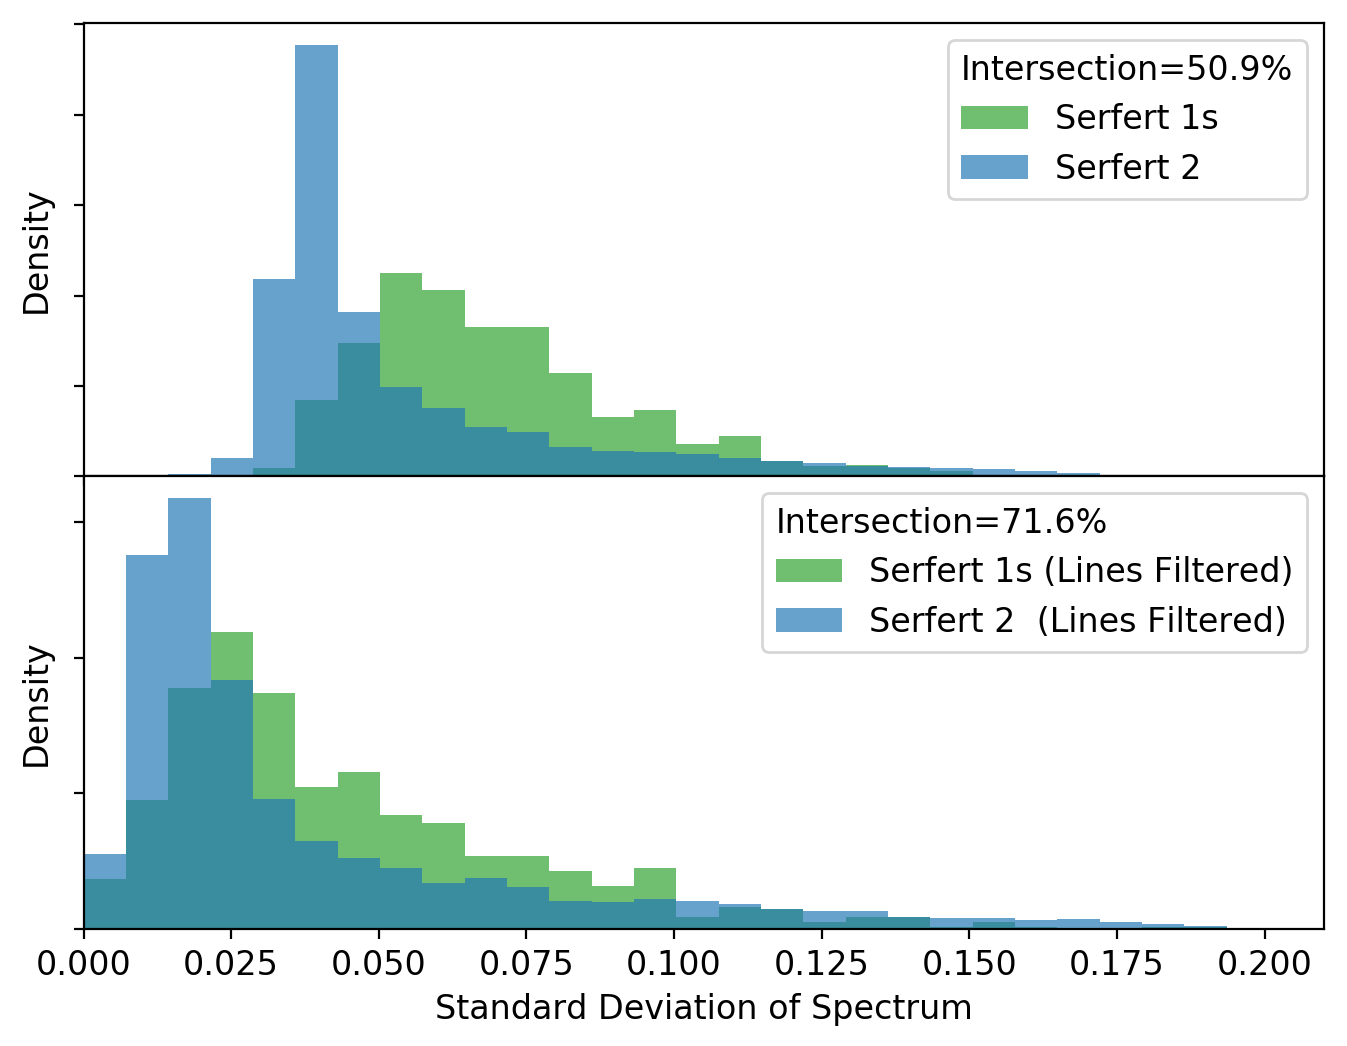

In [38]:
# Normalize
bins = np.linspace(0,0.38,54)
kwargs = dict(alpha=0.68, bins=bins, density=True, stacked=True)
kwargs2 = dict(alpha=0.5, bins=bins, density=True, stacked=True)


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8,6), sharex=True, sharey=False)
plt.subplots_adjust(hspace=0, wspace = 0.05)

plt.sca(axs[0])
axs[0].set_yticklabels([])
sy19_org_hist = plt.hist(sy19_org_std, **kwargs, color='C2', label='Serfert 1s')
sy2_org_hist = plt.hist(sy2_org_std, **kwargs, color='C0', label='Serfert 2')
intersection = np.round(histogram_intersection(sy19_org_hist,sy2_org_hist),3)[2]*100
leg = plt.legend(loc=1, title = 'Intersection='+str(intersection)+'%')
leg._legend_box.align = "left"
plt.ylabel('Density')
    
plt.sca(axs[1])
axs[1].set_yticklabels([])
sy19_hist = plt.hist(sy19_std, **kwargs, color='C2', label='Serfert 1s (Lines Filtered)')
#plt.hist(sy19_noise_std, **kwargs, color='r', label='Serfert 1s (Lines Filtered)')
sy2_hist = plt.hist(sy2_std, **kwargs, color='C0', label='Serfert 2  (Lines Filtered)')
intersection = np.round(histogram_intersection(sy19_hist,sy2_hist),3)[2]*100
leg = plt.legend(loc=1, title = 'Intersection='+str(intersection)+'%')
leg._legend_box.align = "left"

plt.xlabel('Standard Deviation of Spectrum')
plt.ylabel('Density')
plt.xlim(0,0.21)

# Minimal and Maximun Varibility 

In [39]:
sy2_min_index, sy2_max_index = np.argmin(sy19_std),np.argmax(sy2_std)
sy19_min_index, sy19_max_index = np.argmin(sy19_std),np.argmax(sy19_std)

Text(0, 0.5, 'Normalized Flux')

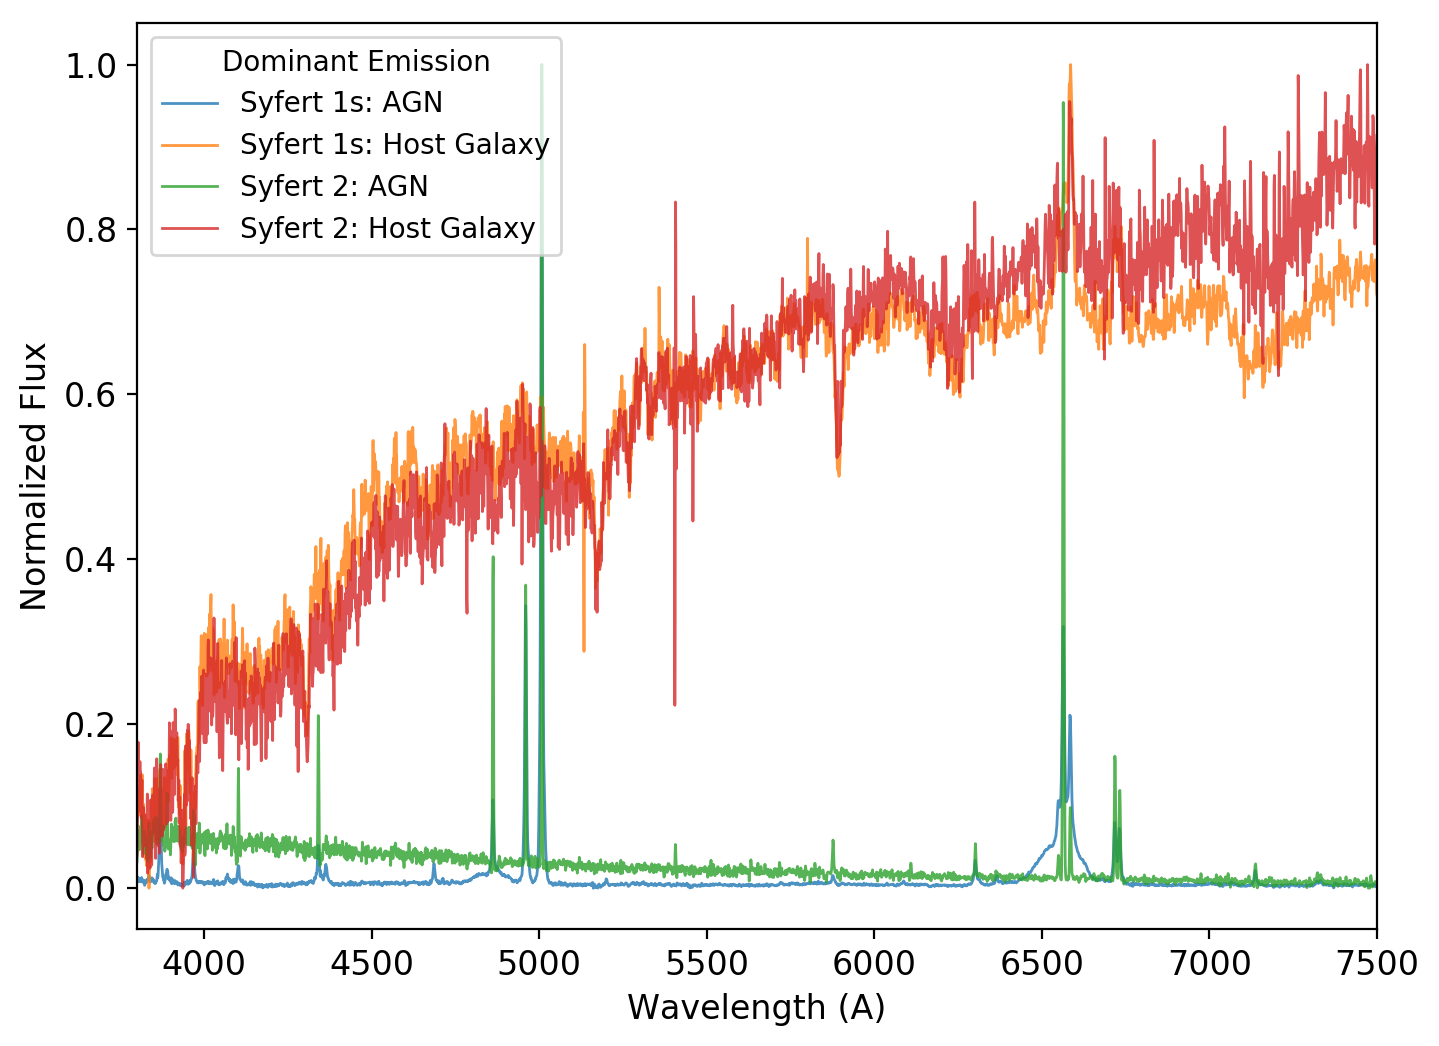

In [40]:
plotData(sy19_feature[sy19_min_index], alpha=0.8,label='Syfert 1s: AGN')
plotData(sy19_feature[sy19_max_index], alpha=0.8,label='Syfert 1s: Host Galaxy')
plotData(sy20_feature[sy2_min_index], alpha=0.8, label='Syfert 2: AGN')
plotData(sy20_feature[sy2_max_index], alpha=0.8,label='Syfert 2: Host Galaxy')
leg=plt.legend(title='Dominant Emission',fontsize=10,loc=2)
plt.setp(leg.get_title(),fontsize=10)
plt.xlim(3800,7500)
plt.xlabel('Wavelength (A)')
plt.ylabel('Normalized Flux')

In [42]:
sy19_feature[sy19_min_index]

tensor([0.0138, 0.0101, 0.0077,  ..., 0.0034, 0.0039, 0.0039])

In [43]:
sy19_min_index

328

# Average Spectrum

In [ ]:
sy19_mean=torch.mean(sy19_feature_filtered,dim=0,keepdim=False)
sy2_mean=torch.mean(sy20_feature_filtered,dim=0,keepdim=False)

sy19_org_mean=torch.mean(sy19_feature,dim=0,keepdim=False)
sy2_org_mean=torch.mean(sy20_feature,dim=0,keepdim=False)

In [ ]:
#plotData(sy19_mean,label='Syfert 1s')
#plotData(sy2_mean,label='Syfert 2')

plotData(sy19_org_mean, color='C2', alpha=0.8, label='Syfert 1s')
plotData(sy2_org_mean, color='C0',alpha=0.8, label='Syfert 2')
plotData(sy2_org_mean+0.028, color='grey',alpha=0.5, label='Syfert 2 Shifted')



leg=plt.legend(title='Averaged Spectrum',fontsize=10,loc=2)
plt.setp(leg.get_title(),fontsize=10)
#plt.xlim(3800,7500)
plt.xlabel('Wavelength (A)')
plt.ylabel('Normalized Flux')

In [ ]:
sy19_org_mean=torch.mean(sy19_feature,dim=0,keepdim=False)
sy2_org_mean=torch.mean(sy20_feature,dim=0,keepdim=False)

In [ ]:
spec = sy20_feature[6809]
spec_mean = spec.mean().item()
spec_std = spec.std().item()
plotData(spec)
xs = np.linspace(3800,7500,3701)
amp = np.random.uniform(low=spec_mean, high=spec_mean)
index = np.random.uniform(low=-2.5, high=-1.5)
ys = _powerLaw(xs, amp, index, ePiv=3800)
plt.plot(xs,ys)
plt.plot(xs,spec.numpy()+ys)

In [ ]:
sy2_std.min()

In [ ]:
sy20_feature[4].numpy()